# 3 layer LSTM Encoder Decoder, dropout. 120 day input, 10 day forecast

In [1]:
import numpy as np
import pandas as pd
import json
import os
import math
import datetime as dt
import matplotlib.pyplot as plt
from numpy import newaxis
from keras.optimizers import Adam
from keras.layers import Conv1D, Dense, Activation, Dropout, LSTM, CuDNNLSTM, BatchNormalization, RepeatVector, TimeDistributed
from keras.models import Sequential, load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras import regularizers

import utils
import model_funcs

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [16, 9]
%matplotlib inline

Using TensorFlow backend.


In [2]:
save_dir = 'models/lstm4.68'
df = pd.read_csv('data_25_orig.csv', index_col='Date')
num_skew_end = 15
data = df.values[:-num_skew_end]

In [3]:
num_input = 120
num_out = 10
train_X, train_y, dev_X, dev_y, test_X, test_y, train_y_acc, dev_y_acc, test_y_acc = \
    utils.prepare_data(data, num_input, num_preds=num_out, standardize=True)

train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y = dev_y.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))
train_y_acc = train_y_acc.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y_acc = dev_y_acc.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y_acc = test_y_acc.reshape((test_y.shape[0], test_y.shape[1], 1))

print("train_X shape", train_X.shape)
print("train_y shape", train_y.shape)
print("dev_X shape", dev_X.shape)
print("dev_y shape", dev_y.shape)
print("test_X shape", test_X.shape)
print("test_y shape", test_y.shape)
print("train_y_acc shape", train_y_acc.shape)
print("dev_y_acc shape", dev_y_acc.shape)
print("test_y_acc shape", test_y_acc.shape)


train_X shape (585, 120, 25)
train_y shape (585, 10, 1)
dev_X shape (69, 120, 25)
dev_y shape (69, 10, 1)
test_X shape (35, 120, 25)
test_y shape (35, 10, 1)
train_y_acc shape (585, 10, 1)
dev_y_acc shape (69, 10, 1)
test_y_acc shape (35, 10, 1)


In [4]:
if not os.path.exists(save_dir): os.makedirs(save_dir)

input_shape = train_X.shape[1:]
lr = 0.0005
decay = 1e-6
dropout_rate = 0.3
epochs = 1000
batch_size = 32

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=10, activation='relu', input_shape=input_shape))
model.add(CuDNNLSTM(200))
model.add(Dropout(dropout_rate))
model.add(RepeatVector(num_out))
model.add(CuDNNLSTM(200, return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))

opt = Adam(lr=lr, decay=decay)
model.compile(loss="mae", optimizer=opt)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 111, 64)           16064     
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 200)               212800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 200)           0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 10, 200)           321600    
_________________________________________________________________
dropout_2 (Dropout)  

In [5]:
history = model_funcs.train(
    model,
    train_X,
    train_y,
    (dev_X, dev_y),
    epochs = epochs,
    batch_size = batch_size,
    save_dir = save_dir
)

[Model] Training Started
[Model] 1000 epochs, 32 batch size
Instructions for updating:
Use tf.cast instead.
Train on 585 samples, validate on 69 samples
Epoch 1/1000
585/585 [==============================] - 2s 4ms/step - loss: 0.3552 - val_loss: 0.2867
Epoch 2/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.2058 - val_loss: 0.1791
Epoch 3/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.1769 - val_loss: 0.1895
Epoch 4/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.1688 - val_loss: 0.1400
Epoch 5/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.1471 - val_loss: 0.1343
Epoch 6/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.1371 - val_loss: 0.1449
Epoch 7/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.1268 - val_loss: 0.1202
Epoch 8/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.1207 - val_loss: 0.1282
Epoch 9/1000
585/585 [=========

Epoch 77/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0668 - val_loss: 0.0728
Epoch 78/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0671 - val_loss: 0.0786
Epoch 79/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0657 - val_loss: 0.0711
Epoch 80/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0665 - val_loss: 0.0757
Epoch 81/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0700 - val_loss: 0.0784
Epoch 82/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0681 - val_loss: 0.0749
Epoch 83/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0663 - val_loss: 0.0830
Epoch 84/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0676 - val_loss: 0.0862
Epoch 85/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0673 - val_loss: 0.0717
Epoch 86/1000
585/585 [==============================] - 1s 1ms/step - lo

Epoch 156/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0584 - val_loss: 0.0704
Epoch 157/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0572 - val_loss: 0.0654
Epoch 158/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0568 - val_loss: 0.0718
Epoch 159/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0563 - val_loss: 0.0787
Epoch 160/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0586 - val_loss: 0.0867
Epoch 161/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0571 - val_loss: 0.0808
Epoch 162/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0574 - val_loss: 0.0757
Epoch 163/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0602 - val_loss: 0.0735
Epoch 164/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0566 - val_loss: 0.0674
Epoch 165/1000
585/585 [==============================] - 1s 1ms

Epoch 235/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0525 - val_loss: 0.0720
Epoch 236/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0516 - val_loss: 0.0647
Epoch 237/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0510 - val_loss: 0.0748
Epoch 238/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0536 - val_loss: 0.0720
Epoch 239/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0518 - val_loss: 0.0683
Epoch 240/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0513 - val_loss: 0.0593
Epoch 241/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0537 - val_loss: 0.0623
Epoch 242/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0513 - val_loss: 0.0712
Epoch 243/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0547 - val_loss: 0.0665
Epoch 244/1000
585/585 [==============================] - 1s 1ms

Epoch 314/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0494 - val_loss: 0.0940
Epoch 315/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0491 - val_loss: 0.0755
Epoch 316/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0477 - val_loss: 0.0757
Epoch 317/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0470 - val_loss: 0.0674
Epoch 318/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0483 - val_loss: 0.0684
Epoch 319/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0471 - val_loss: 0.0824
Epoch 320/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0480 - val_loss: 0.0718
Epoch 321/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0484 - val_loss: 0.0884
Epoch 322/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0483 - val_loss: 0.0786
Epoch 323/1000
585/585 [==============================] - 1s 1ms

Epoch 393/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0472 - val_loss: 0.0621
Epoch 394/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0451 - val_loss: 0.0706
Epoch 395/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0457 - val_loss: 0.0743
Epoch 396/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0439 - val_loss: 0.0686
Epoch 397/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0444 - val_loss: 0.0567
Epoch 398/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0441 - val_loss: 0.0777
Epoch 399/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0448 - val_loss: 0.0797
Epoch 400/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0475 - val_loss: 0.0657
Epoch 401/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0492 - val_loss: 0.0715
Epoch 402/1000
585/585 [==============================] - 1s 1ms

Epoch 472/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0433 - val_loss: 0.0715
Epoch 473/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0421 - val_loss: 0.0804
Epoch 474/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0432 - val_loss: 0.0743
Epoch 475/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0419 - val_loss: 0.0713
Epoch 476/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0427 - val_loss: 0.0773
Epoch 477/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0431 - val_loss: 0.0594
Epoch 478/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0426 - val_loss: 0.0687
Epoch 479/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0429 - val_loss: 0.0653
Epoch 480/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0409 - val_loss: 0.0677
Epoch 481/1000
585/585 [==============================] - 1s 1ms

Epoch 551/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0397 - val_loss: 0.0728
Epoch 552/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0411 - val_loss: 0.0717
Epoch 553/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0403 - val_loss: 0.0732
Epoch 554/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0387 - val_loss: 0.0654
Epoch 555/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0392 - val_loss: 0.0699
Epoch 556/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0389 - val_loss: 0.0823
Epoch 557/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0398 - val_loss: 0.0712
Epoch 558/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0399 - val_loss: 0.0753
Epoch 559/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0392 - val_loss: 0.0755
Epoch 560/1000
585/585 [==============================] - 1s 1ms

Epoch 630/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0371 - val_loss: 0.0779
Epoch 631/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0383 - val_loss: 0.0697
Epoch 632/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0381 - val_loss: 0.0747
Epoch 633/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0381 - val_loss: 0.0783
Epoch 634/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0375 - val_loss: 0.0736
Epoch 635/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0378 - val_loss: 0.0718
Epoch 636/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0366 - val_loss: 0.0704
Epoch 637/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0377 - val_loss: 0.0680
Epoch 638/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0370 - val_loss: 0.0755
Epoch 639/1000
585/585 [==============================] - 1s 1ms

Epoch 709/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0396 - val_loss: 0.0876
Epoch 710/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0376 - val_loss: 0.0718
Epoch 711/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0365 - val_loss: 0.0753
Epoch 712/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0364 - val_loss: 0.0773
Epoch 713/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0361 - val_loss: 0.0726
Epoch 714/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0363 - val_loss: 0.0787
Epoch 715/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0362 - val_loss: 0.0700
Epoch 716/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0368 - val_loss: 0.0846
Epoch 717/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0371 - val_loss: 0.0659
Epoch 718/1000
585/585 [==============================] - 1s 1ms

Epoch 788/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0342 - val_loss: 0.0654
Epoch 789/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0341 - val_loss: 0.0760
Epoch 790/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0345 - val_loss: 0.0708
Epoch 791/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0348 - val_loss: 0.0767
Epoch 792/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0358 - val_loss: 0.0678
Epoch 793/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0343 - val_loss: 0.0813
Epoch 794/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0353 - val_loss: 0.0838
Epoch 795/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0351 - val_loss: 0.0695
Epoch 796/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0352 - val_loss: 0.0923
Epoch 797/1000
585/585 [==============================] - 1s 1ms

Epoch 867/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0340 - val_loss: 0.0703
Epoch 868/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0326 - val_loss: 0.0710
Epoch 869/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0329 - val_loss: 0.0777
Epoch 870/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0340 - val_loss: 0.0771
Epoch 871/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0336 - val_loss: 0.0700
Epoch 872/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0353 - val_loss: 0.0682
Epoch 873/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0336 - val_loss: 0.0782
Epoch 874/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0329 - val_loss: 0.0705
Epoch 875/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0331 - val_loss: 0.0786
Epoch 876/1000
585/585 [==============================] - 1s 1ms

Epoch 946/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0329 - val_loss: 0.0828
Epoch 947/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0334 - val_loss: 0.0704
Epoch 948/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0328 - val_loss: 0.0672
Epoch 949/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0323 - val_loss: 0.0888
Epoch 950/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0329 - val_loss: 0.0762
Epoch 951/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0324 - val_loss: 0.0769
Epoch 952/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0322 - val_loss: 0.0709
Epoch 953/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0323 - val_loss: 0.0740
Epoch 954/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0312 - val_loss: 0.0751
Epoch 955/1000
585/585 [==============================] - 1s 1ms

In [6]:
preds_train = model.predict(train_X).squeeze()
preds_dev = model.predict(dev_X).squeeze()
preds_test = model.predict(test_X).squeeze()
print("MSE Train:", mean_squared_error(preds_train.reshape(-1,1), train_y.reshape(-1,1)))
print("MSE Dev:", mean_squared_error(preds_dev.reshape(-1,1), dev_y.reshape(-1,1)))
print("MSE Test:", mean_squared_error(preds_test.reshape(-1,1), test_y.reshape(-1,1)))

print("MAE Train:", mean_absolute_error(preds_train.reshape(-1,1), train_y.reshape(-1,1)))
print("MAE Dev:", mean_absolute_error(preds_dev.reshape(-1,1), dev_y.reshape(-1,1)))
print("MAE Test:", mean_absolute_error(preds_test.reshape(-1,1), test_y.reshape(-1,1)))

MSE Train: 0.011511849733325072
MSE Dev: 0.022139354817142992
MSE Test: 0.005008602522265038
MAE Train: 0.0706914886809679
MAE Dev: 0.09424044990183221
MAE Test: 0.060736363878866266


In [7]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

l = go.Scatter(y=history.history['loss'], name='train')
v = go.Scatter(y=history.history['val_loss'], name='dev')

data = [v,l]
py.iplot(data, filename='line-mode')

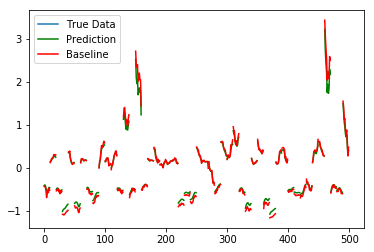

In [8]:
predicted_train = model.predict(train_X).squeeze()
predicted_train = predicted_train[::num_out]
true_train = train_y[::num_out].squeeze()
utils.plot_results_multiple(predicted_train.tolist()[:50], [], num_out, baseline_data=true_train.tolist()[:50])

# predicted_train = model.predict(train_X).squeeze()
# predicted_train = predicted_train[:, 0].reshape(-1,1)
# true_train = train_y[:, 0].reshape(-1,1)
# utils.plot_results(predicted_train[:50], true_train[:50])

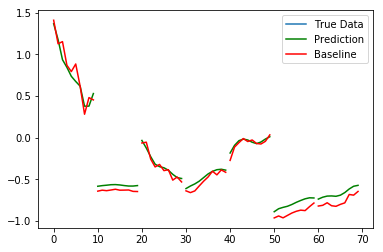

VAR MAE Dev: 0.12914781362785555
LSTM MAE Dev: 0.0060928792612060184
VAR MSE Dev: 0.12914781362785555
LSTM MSE Dev: 0.0060928792612060184


In [9]:
predicted_dev = model.predict(dev_X).squeeze()
predicted_dev = predicted_dev[::num_out]
true_dev = dev_y[::num_out].squeeze()
utils.plot_results_multiple(predicted_dev.tolist(), [0], num_out, baseline_data=true_dev.tolist())

true_dev = true_dev.reshape(-1,1)

var_preds_dev = utils.var_predict(dev_X[:, :, 0:5], num_out)
var_preds_dev = var_preds_dev[::num_out]

print("VAR MAE Dev:", mean_squared_error(var_preds_dev.reshape(-1,1), true_dev))
print("LSTM MAE Dev:", mean_squared_error(predicted_dev.reshape(-1,1), true_dev))

print("VAR MSE Dev:", mean_squared_error(var_preds_dev.reshape(-1,1), true_dev))
print("LSTM MSE Dev:", mean_squared_error(predicted_dev.reshape(-1,1), true_dev))

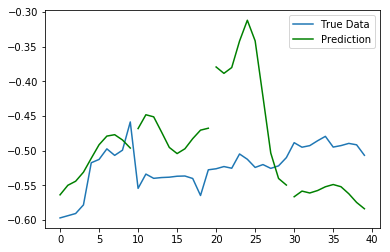

In [10]:
predicted_test = model.predict(test_X).squeeze()
predicted_test = predicted_test[::num_out]
true_test = test_y[::num_out].reshape(-1,1)
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out)

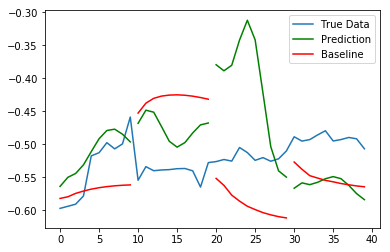

VAR MAE Test: 0.07146488780346479
LSTM MAE Test: 0.07008459961999378
VAR MSE Test: 0.00609307563783308
LSTM MSE Test: 0.007016212466486193


In [11]:
var_preds = utils.var_predict(test_X[:, :, 0:5], num_out)
var_preds = var_preds[::num_out]
    
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out, baseline_data=var_preds.tolist())

print("VAR MAE Test:", mean_absolute_error(var_preds.reshape(-1,1), true_test))
print("LSTM MAE Test:", mean_absolute_error(predicted_test.reshape(-1,1), true_test))

print("VAR MSE Test:", mean_squared_error(var_preds.reshape(-1,1), true_test))
print("LSTM MSE Test:", mean_squared_error(predicted_test.reshape(-1,1), true_test))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



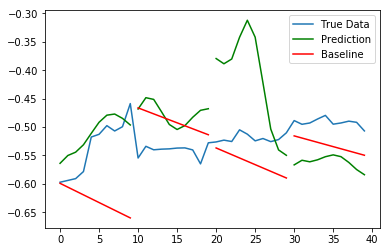

ARIMA MAE Test: 0.05753268381072618
LSTM MAE Test: 0.07008459961999378
ARIMA MSE Test: 0.005073242730985301
LSTM MSE Test: 0.007016212466486193


In [12]:
arima_preds = utils.arima_predict(test_X[:, :, 0], num_out)
arima_preds = arima_preds[::num_out]
    
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out, baseline_data=arima_preds.tolist())

print("ARIMA MAE Test:", mean_absolute_error(arima_preds.reshape(-1,1), true_test))
print("LSTM MAE Test:", mean_absolute_error(predicted_test.reshape(-1,1), true_test))

print("ARIMA MSE Test:", mean_squared_error(arima_preds.reshape(-1,1), true_test))
print("LSTM MSE Test:", mean_squared_error(predicted_test.reshape(-1,1), true_test))

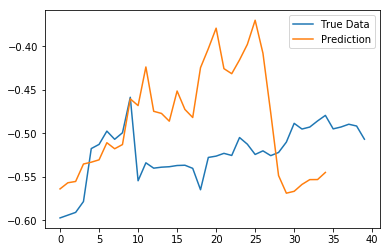

In [13]:
predicted_test_single = model.predict(test_X).squeeze()
predicted_test_single = predicted_test_single[:, 0]
utils.plot_results(predicted_test_single, true_test)